# An improved implementation of a high-pass filter

Let's begin by exploring what was wrong with our naive implementation. To illustrate this let's extend our first example. We'll generate the same dataset, but instead of generating 8 seconds of data, I'll generate 1024 seconds of data and then cut the data to only keep 8 seconds of that data in the middle.

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

In [25]:
# Choose data length and sampling rate
omega = 1. * (2*np.pi)
data_length = 1024
sample_rate = 16
sample_points = int(data_length * sample_rate)

times = np.arange(sample_points) / sample_rate
data_time_domain = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length)*2 + 1):
    omega = i / (2*data_length) * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain += 100*np.sin(times * omega + phase)

# Add in a single 4Hz sine wave
omega = 4. * (2*np.pi)
data_time_domain += np.sin(times * omega)

data_time_domain_CUT = data_time_domain[504*sample_rate:512*sample_rate]

## Exercise

As in part 1, plot this CUT data in the Fourier domain, and transform back to the time domain.

Then, as before, transform the CUT data to the Fourier domain, perform a basic high-pass filter, as we did previously, and plot the data again.

Can you see the sine wave on any of this data? (The answer now should be "no")

We did the same process as in the previous step, where we *did* manage to extract the signal. So what's the difference here? Why can we not recover the signal in this case?

To answer this we need to think about the theory of Fourier transforms: As we said previously, any discrete time series can be represented as a frequency series by a Fourier transform. However, **this assumes that the data is cyclical**, this means that the data should repeat itself. So in the time domain, we consider that when we reach the end of the dataset we start again at the beginning.

This was not a problem in our first example, because we generated the noise such that the end was smoothly connected to the start. We can see this by repeating the dataset and examining the "join":

In [29]:
# Generate our short dataset again
# Choose data length and sampling rate
omega = 1. * (2*np.pi)
data_length_short = 8
sample_rate = 16
sample_points = int(data_length_short * sample_rate)
times_SHORT = np.arange(sample_points) / sample_rate
times_SHORT_TWICE = np.arange(sample_points*2) / sample_rate

data_time_domain_SHORT = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length+1)):
    omega = i / data_length * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_SHORT += 100*np.sin(times_SHORT * omega + phase)

# Add in a single 4Hz sine wave
omega = 4. * (2*np.pi)
data_time_domain_SHORT += np.sin(times_SHORT * omega)

Text(0, 0.5, 'Amplitude')

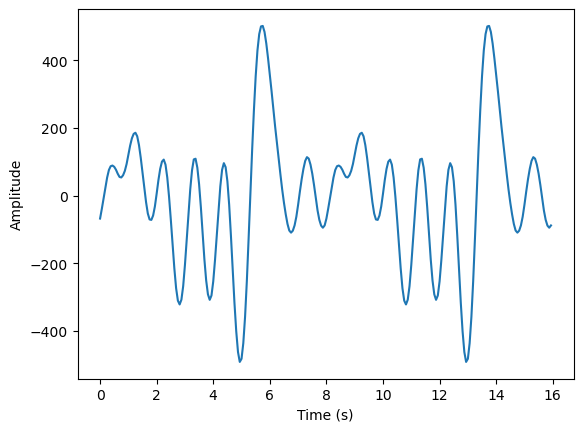

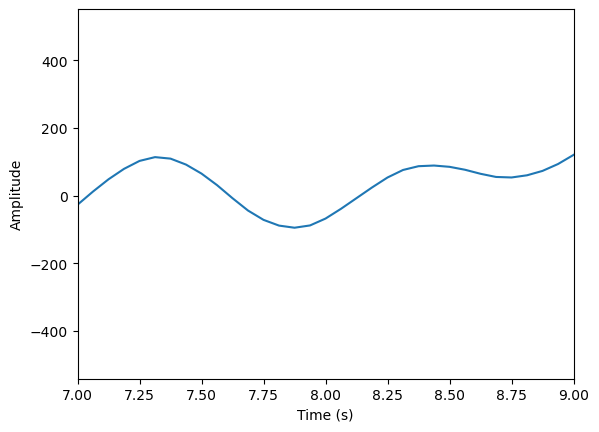

In [5]:
# Here I am talking the 16 seconds of data, and then *repeating* it so we have 32 seconds of data, where the first
# 16 seconds is identical to the last 16 seconds.
plt.plot(times_SHORT_TWICE, np.append(data_time_domain_SHORT, data_time_domain_SHORT))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times_SHORT_TWICE, np.append(data_time_domain_SHORT, data_time_domain_SHORT))
plt.xlabel('Time (s)')
plt.xlim([data_length_short-1,data_length_short+1])
plt.ylabel('Amplitude')


In this case we can see that the data is repeating and the "join" is smooth. In contrast, for our CUT dataset:

Text(0, 0.5, 'Amplitude')

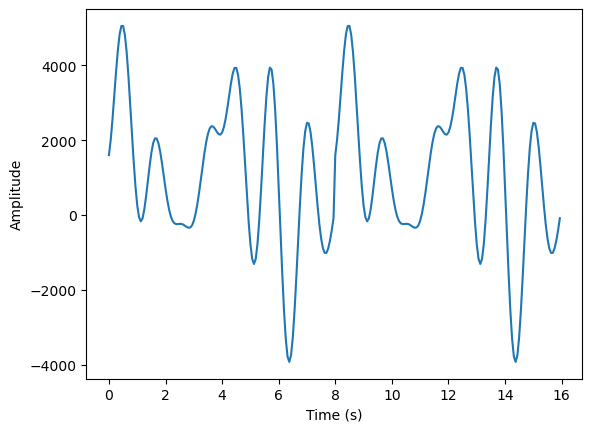

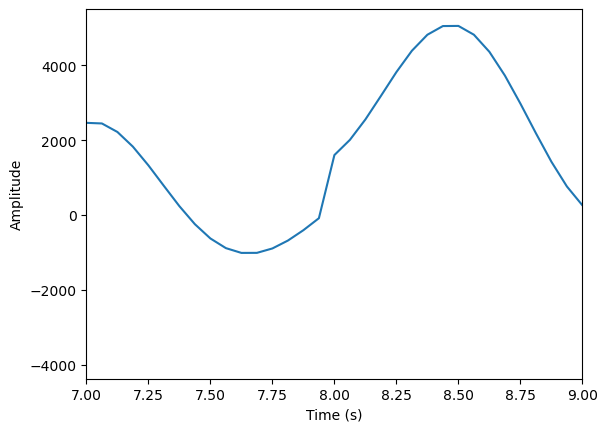

In [30]:
plt.plot(times_SHORT_TWICE, np.append(data_time_domain_CUT, data_time_domain_CUT))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times_SHORT_TWICE, np.append(data_time_domain_CUT, data_time_domain_CUT))
plt.xlabel('Time (s)')
plt.xlim([data_length_short-1,data_length_short+1])
plt.ylabel('Amplitude')


We can see above that the transition here is *not* smooth (run the code and generate the plot again if this is not so clear). Joining these two datasets introduces a delta-function in the data. As we saw earlier a discontinuity, or delta-function, produces broad frequency content in the Fourier transform. The high-pass filter removes a lot of this content, but cannot remove the content above 1Hz.

Unfortunately, most real examples will look like the case above, and not the simple case.

So how do we deal with this? In short, we have to remove this discontinuity!

Let's first deal with the case that I am *only* concerned about my 8s data set for now. If I want to get rid of the delta-function. I can "window" the data. This means that data at the edges is set to 0, by multiplying be some sort of smooth curve between 0 and 1 (called a window function). Let's show a quick example of this and then explain a bit more:

Text(0, 0.5, 'Amplitude')

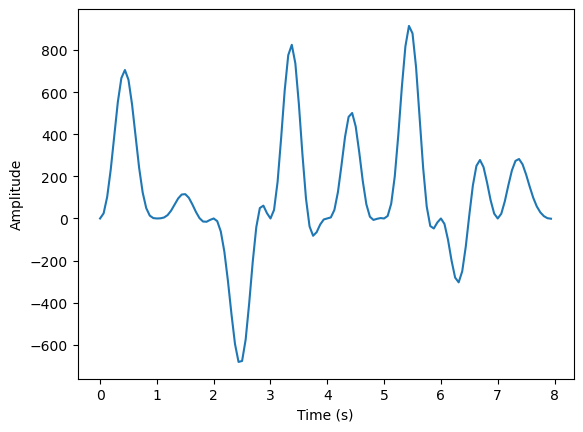

In [20]:
# IMPORTANT TO USE COPY HERE SO WE DON'T EDIT BOTH ARRAYS!!
data_time_domain_CUT_windowed = np.copy(data_time_domain_CUT[:])
npoints = data_length-1

data_time_domain_CUT_windowed[:npoints] = (
    data_time_domain_CUT_windowed[:npoints] * (0.5 - 0.5*np.cos(times_SHORT[:npoints] * np.pi))
)
data_time_domain_CUT_windowed[-npoints:] = (
    data_time_domain_CUT_windowed[-npoints:] * (0.5 + 0.5*np.cos(times_SHORT[:npoints] * np.pi))
)
    
# NOTE: times_SHORT[:npoints] goes from 0 to (almost) 1, so the factor on the right above here is a cosine
# transitioning from 0 to 1 (or vice versa)

plt.plot(times_SHORT, data_time_domain_CUT_windowed)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


What we have done here is taper the data to 0 at both ends. This will remove some actual content from the data, but will ensure that the data meets (mostly) smoothly at the ends (the second derivative is not continuous at this point, so it is not truly smooth with the window I chose!) We can, however, see that this data joins up much better in the middle.


## Exercise

Show that the data is now smooth if we join the start of the data to the end (by making the same plot as we made above over 16 seconds). Then Fourier transform this data again, and see if we can see the signal now. Also use our basic high-pass filter on this windowed data and see if we can extract the signal in the time domain. HINT: Try removing data up to 3Hz to improve ability to extract the signal!

In this case, we should be able to see a spike in the Fourier domain data at 4Hz, but the windowing itself introduces some noise at all frequencies, and we do not perfectly recover the sine wave .... This is the general real-world example! This could be improved by (for example) using a better windowing function. For example we could have windowed more data, smoothing out the noise due to the window, but removing more of the data. There's also a variety of possible ways to smoothly bring data to 0:

https://en.wikipedia.org/wiki/Window_function

Some of which may perform well in this instance.

## Optional Exercise

Investigate if you can better recover the signal in this 8 seconds CUT dataset by using different windowing filters, or different filter lengths.

However, we should remember that our CUT dataset was in total 1024 seconds long. If we are able to use the *full* dataset, we should be better able to extract the signal! One approach to doing this would be to just analyse the full dataset in one go. We can Fourier transform the full set, we could window (for example) 8 seconds of data on either end, and hopefully extract the signal well.

## Exercise


Can you recover the signal from directly analysing the full 1024 seconds of data, as described above? (In a short test case, I was able to clearly see the content in the frequency domain).